In [1]:
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 383.6/383.6 kB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 231.8/231.8 kB 24.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.5/78.5 kB 9.5 MB/s eta 0:00:00


## Base Paper Implementation

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, RandomizedSearchCV, KFold
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import LSTM, Dense
import xgboost as xgb
import shap
import warnings
warnings.filterwarnings("ignore")

In [3]:
# Load dataset from the Excel file
data = pd.read_excel("Dataset.xlsx")

# Convert Date column to datetime, sort by date, and set it as index
data['Date'] = pd.to_datetime(data['Date'])
data.sort_values('Date', inplace=True)
data.set_index('Date', inplace=True)

# Display the first few rows
data.head()

,WTI Spot (Dollars per barrel),US Dollar Index,Index of global real economic \nactivity,10 Year Bond Yield for USA (Index),Gold Price (USD)
Date,,,,,
1986-01-15,22.93,121.52,-37.805407,108.5,352.9
1986-02-15,15.46,115.08,-51.757371,102.7,341.0
1986-03-15,12.61,117.92,-55.398690,91.8,334.8
1986-04-15,12.84,111.77,-61.561085,86.2,348.1
1986-05-15,15.38,117.51,-66.396952,91.0,347.1


In [4]:
# Define feature and target columns
feature_cols = data.columns[2:]
target_col = data.columns[1]

# Initialize scalers for features and target
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

# Scale features and target separately
X_scaled = scaler_X.fit_transform(data[feature_cols])
y_scaled = scaler_y.fit_transform(data[[target_col]])

# Function to create sequences for LSTM input
def create_sequences(X, y, seq_length):
    Xs, ys = [], []
    for i in range(len(X) - seq_length):
        Xs.append(X[i:i+seq_length])
        ys.append(y[i+seq_length])
    return np.array(Xs), np.array(ys)

seq_length = 12  # e.g., use the past 12 months to predict the next value
X_seq, y_seq = create_sequences(X_scaled, y_scaled, seq_length)

# Split data into training (80%) and testing (20%) sets
split = int(0.8 * len(X_seq))
X_train, X_test = X_seq[:split], X_seq[split:]
y_train, y_test = y_seq[:split], y_seq[split:]

In [5]:
# Define model parameters
lstm_units = 50

# Build the LSTM model. The LSTM layer is named 'lstm_feature' to extract its output later.
lstm_model = Sequential([
    LSTM(lstm_units, input_shape=(X_train.shape[1], X_train.shape[2]),
         return_sequences=False, name='lstm_feature'),
    Dense(1, activation='linear')
])

lstm_model.compile(optimizer='adam', loss='mse')
lstm_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_feature (LSTM)                  │ (None, 50)                  │          10,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 10,851 (42.39 KB)

 Trainable params: 10,851 (42.39 KB)

 Non-trainable params: 0 (0.00 B)

In [6]:
# Set training parameters
epochs = 50
batch_size = 16

# Train the model with a validation split to monitor performance
history = lstm_model.fit(X_train, y_train,
                         epochs=epochs,
                         batch_size=batch_size,
                         validation_split=0.1,
                         verbose=1)

Epoch 1/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 4s 58ms/step - loss: 0.0950 - val_loss: 0.1145
Epoch 2/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0446 - val_loss: 0.1398
Epoch 3/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0367 - val_loss: 0.1155
Epoch 4/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0354 - val_loss: 0.0972
Epoch 5/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0335 - val_loss: 0.0957
Epoch 6/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0282 - val_loss: 0.0784
Epoch 7/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0249 - val_loss: 0.0730
Epoch 8/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0194 - val_loss: 0.0433
Epoch 9/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0181 - val_loss: 0.0325
Epoch 10/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0177 - val_loss: 0.0209
Epoch 11/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0211 - val_loss: 0.0360
Epoch 12/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0178 - 

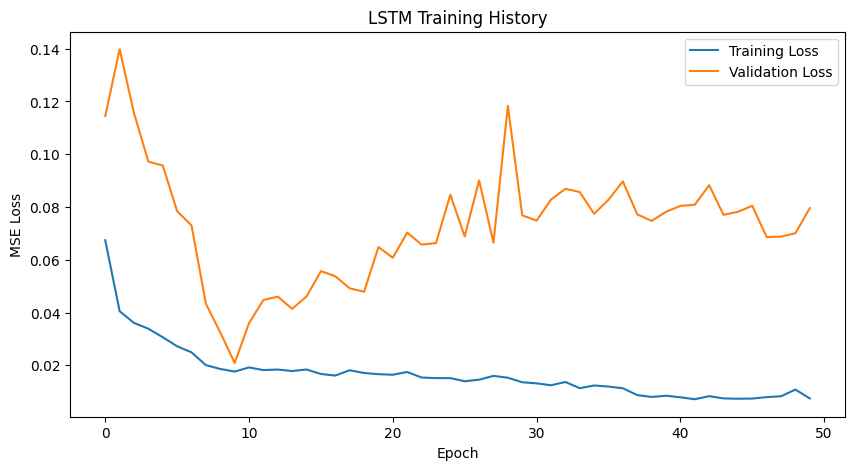

In [7]:
plt.figure(figsize=(10,5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.title('LSTM Training History')
plt.legend()
plt.show()

In [8]:
from tensorflow.keras.layers import Input, LSTM, Dense
from tensorflow.keras.models import Model

# Define the input layer with the appropriate shape
inputs = Input(shape=(X_train.shape[1], X_train.shape[2]))

# Define the LSTM layer and name it for later extraction
x = LSTM(lstm_units, return_sequences=False, name='lstm_feature')(inputs)

# Define the output layer
outputs = Dense(1, activation='linear')(x)

# Build the functional model
lstm_model = Model(inputs=inputs, outputs=outputs)
lstm_model.compile(optimizer='adam', loss='mse')
lstm_model.summary()

# Train the model (adjust epochs and batch_size as needed)
history = lstm_model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_split=0.1, verbose=1)

# Now, create a feature extractor model using the defined input and the output of 'lstm_feature'
feature_extractor = Model(inputs=lstm_model.input, outputs=lstm_model.get_layer('lstm_feature').output)

# Extract features from training and testing sequences using the feature extractor
X_train_features = feature_extractor.predict(X_train)
X_test_features = feature_extractor.predict(X_test)

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 12, 3)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_feature (LSTM)                  │ (None, 50)                  │          10,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 10,851 (42.39 KB)

 Trainable params: 10,851 (42.39 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.2174 - val_loss: 0.0508
Epoch 2/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0503 - val_loss: 0.1083
Epoch 3/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0325 - val_loss: 0.1160
Epoch 4/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0398 - val_loss: 0.1298
Epoch 5/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0344 - val_loss: 0.1182
Epoch 6/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0280 - val_loss: 0.0992
Epoch 7/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0308 - val_loss: 0.0951
Epoch 8/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0268 - val_loss: 0.0850
Epoch 9/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0274 - val_loss: 0.0891
Epoch 10/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0247 - val_loss: 0.0570
Epoch 11/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0180 - val_loss: 0.0491
Epoch 12/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0172 - 

In [9]:
# Initialize the XGBoost regressor
xgb_reg = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)

# Define hyperparameter search space
param_dist = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.7, 0.8, 1.0]
}

# Use 15-fold cross-validation for hyperparameter tuning via RandomizedSearchCV
cv_kfold = KFold(n_splits=15, shuffle=True, random_state=42)
rand_search = RandomizedSearchCV(xgb_reg, param_distributions=param_dist,
                                 n_iter=10, scoring='neg_mean_squared_error',
                                 cv=cv_kfold, random_state=42, verbose=1)
rand_search.fit(X_train_features, y_train.ravel())

# Retrieve the best estimator
best_xgb = rand_search.best_estimator_
print("Best XGBoost parameters:", rand_search.best_params_)

# Fit the best model on the training features
best_xgb.fit(X_train_features, y_train.ravel())

Fitting 15 folds for each of 10 candidates, totalling 150 fits
Best XGBoost parameters: {'subsample': 0.8, 'n_estimators': 200, 'max_depth': 5, 'learning_rate': 0.1}


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=200, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [11]:
# Predict on the test features
y_pred_scaled = best_xgb.predict(X_test_features)

# Inverse-transform predictions and ground truth to original scale
y_pred = scaler_y.inverse_transform(y_pred_scaled.reshape(-1, 1))
# Create a mask for non-NaN values in y_test_actual
y_test_actual = scaler_y.inverse_transform(y_test)
mask = ~np.isnan(y_test_actual).ravel()
y_test_actual_clean = y_test_actual[mask]
y_pred_clean = y_pred[mask]

# Now calculate the evaluation metrics on the cleaned data
mae = mean_absolute_error(y_test_actual_clean, y_pred_clean)
mse = mean_squared_error(y_test_actual_clean, y_pred_clean)
rmse = np.sqrt(mse)
r2 = r2_score(y_test_actual_clean, y_pred_clean)
mape = np.mean(np.abs((y_test_actual_clean - y_pred_clean) / (y_test_actual_clean + 1e-10))) * 100

print(f"Test MAE: {mae}")
print(f"Test MSE: {mse}")
print(f"Test RMSE: {rmse}")
print(f"Test R2 Score: {r2}")
print(f"Test MAPE: {mape}%")

Test MAE: 17.943720015641098
Test MSE: 389.2921689339281
Test RMSE: 19.73048830956619
Test R2 Score: -11.683425855893399
Test MAPE: 17.8723425338468%


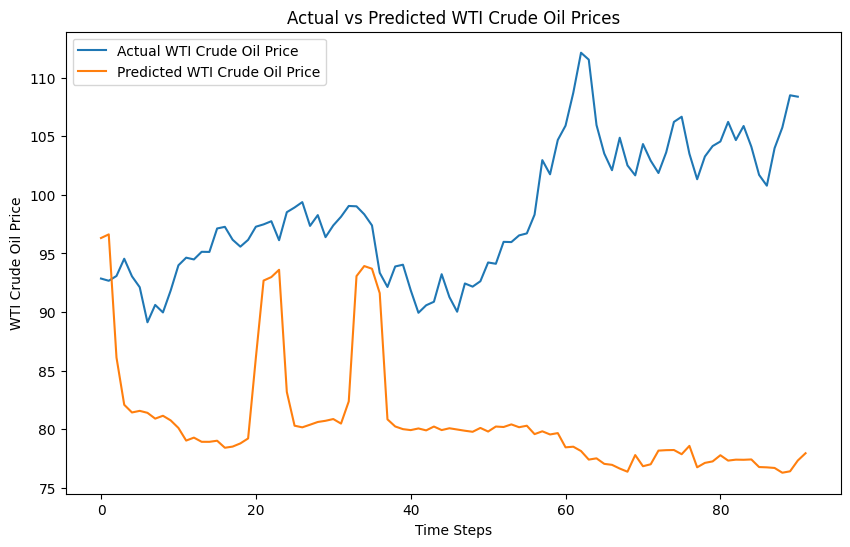

In [12]:
plt.figure(figsize=(10,6))
plt.plot(y_test_actual, label='Actual WTI Crude Oil Price')
plt.plot(y_pred, label='Predicted WTI Crude Oil Price')
plt.xlabel('Time Steps')
plt.ylabel('WTI Crude Oil Price')
plt.title('Actual vs Predicted WTI Crude Oil Prices')
plt.legend()
plt.show()

### Continuous Optimization

In [13]:
import optuna
import xgboost as xgb
import numpy as np
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

# Suppose you have already trained your LSTM model and extracted features:
# X_train_features, y_train, X_test_features, y_test, etc.
# It's best practice to further split your training data into train/validation for Optuna:
X_train_f, X_valid_f, y_train_f, y_valid_f = train_test_split(
    X_train_features, y_train, test_size=0.2, random_state=42
)

In [14]:
import optuna
import xgboost as xgb
import numpy as np
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

def objective(trial):
    # 1. Suggest hyperparameters
    param = {
        'objective': 'reg:squarederror',
        # If you have a GPU, you can use 'gpu_hist' for faster training:
        'tree_method': 'auto',

        'max_depth': trial.suggest_int('max_depth', 2, 12),
        'learning_rate': trial.suggest_loguniform('learning_rate', 1e-4, 1e-1),
        'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5, 1.0),

        # Regularization parameters
        'reg_lambda': trial.suggest_loguniform('lambda', 1e-8, 10.0),
        'reg_alpha': trial.suggest_loguniform('alpha', 1e-8, 10.0),

        # Number of trees (boosting rounds)
        'n_estimators': trial.suggest_int('n_estimators', 50, 500),

        # Include early stopping in constructor
        'early_stopping_rounds': 20,
        'eval_metric': 'rmse'
    }

    # 2. Create an XGBoost model with these hyperparameters
    model = xgb.XGBRegressor(**param)

    # 3. Fit the model, passing eval_set for early stopping
    model.fit(
        X_train_f, y_train_f,
        eval_set=[(X_valid_f, y_valid_f)],
        verbose=False  # or True if you want training logs
    )

    # 4. Evaluate on the validation set
    preds = model.predict(X_valid_f)
    rmse = np.sqrt(mean_squared_error(y_valid_f, preds))
    return rmse

# Then run your Optuna study as before
study = optuna.create_study(direction='minimize', study_name="xgb_opt_study")
study.optimize(objective, n_trials=50, show_progress_bar=True)

print("Number of finished trials:", len(study.trials))
print("Best trial:", study.best_trial.params)

[I 2025-03-18 17:23:26,194] A new study created in memory with name: xgb_opt_study


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2025-03-18 17:23:29,610] Trial 0 finished with value: 0.04641458955614701 and parameters: {'max_depth': 8, 'learning_rate': 0.008102702221553387, 'subsample': 0.8616075145251916, 'colsample_bytree': 0.7538268900065381, 'lambda': 5.182998247189241e-05, 'alpha': 0.007057902216726444, 'n_estimators': 289}. Best is trial 0 with value: 0.04641458955614701.
[I 2025-03-18 17:23:29,966] Trial 1 finished with value: 0.16585148186699245 and parameters: {'max_depth': 3, 'learning_rate': 0.00014819667030314425, 'subsample': 0.6664947697671382, 'colsample_bytree': 0.9952024816337829, 'lambda': 0.0009647254309955843, 'alpha': 0.005696985890932958, 'n_estimators': 149}. Best is trial 0 with value: 0.04641458955614701.
[I 2025-03-18 17:23:30,785] Trial 2 finished with value: 0.1059152950181198 and parameters: {'max_depth': 6, 'learning_rate': 0.004190879196991639, 'subsample': 0.5844992670415253, 'colsample_bytree': 0.5821118111123205, 'lambda': 0.00044505382495537164, 'alpha': 0.000374032834741799

Test MAE: 17.41516587477464
Test MSE: 371.47641767027426
Test RMSE: 19.27372350300466
Test R2 Score: -11.102975545684503
Test MAPE: 17.32410122201225%


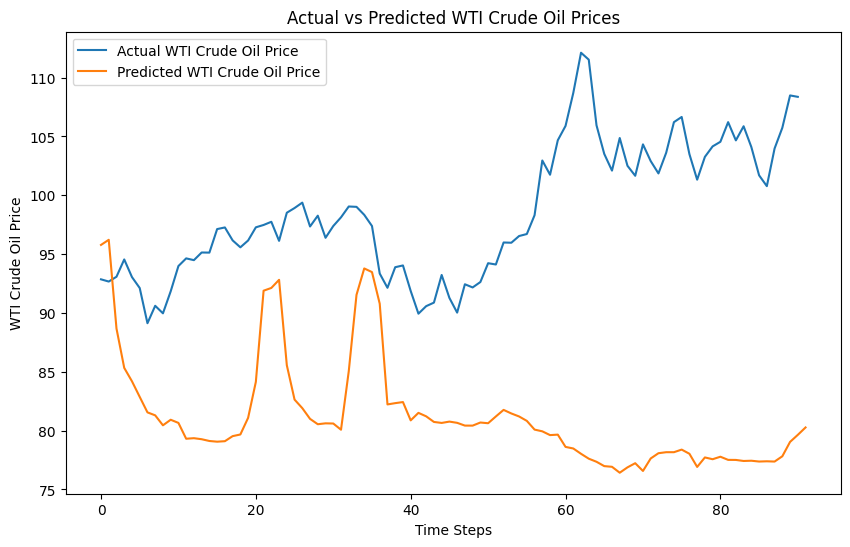

In [15]:
# 1. Retrieve the best hyperparameters from your Optuna study
best_params = study.best_trial.params

# 2. Create a new XGBoost model with those best hyperparameters
best_xgb = xgb.XGBRegressor(**best_params)

# 3. Fit the best model on your entire training set (or combine train & validation)
best_xgb.fit(X_train_features, y_train)

# 4. Predict on the test features
y_pred_scaled = best_xgb.predict(X_test_features)

# 5. Inverse-transform predictions and ground truth to original scale
y_pred = scaler_y.inverse_transform(y_pred_scaled.reshape(-1, 1))
y_test_actual = scaler_y.inverse_transform(y_test)

# 6. (Optional) Remove any NaNs from y_test_actual and corresponding predictions
mask = ~np.isnan(y_test_actual).ravel()
y_test_actual_clean = y_test_actual[mask]
y_pred_clean = y_pred[mask]

# 7. Calculate the evaluation metrics on the cleaned data
mae = mean_absolute_error(y_test_actual_clean, y_pred_clean)
mse = mean_squared_error(y_test_actual_clean, y_pred_clean)
rmse = np.sqrt(mse)
r2 = r2_score(y_test_actual_clean, y_pred_clean)
mape = np.mean(np.abs((y_test_actual_clean - y_pred_clean) / (y_test_actual_clean + 1e-10))) * 100

print(f"Test MAE: {mae}")
print(f"Test MSE: {mse}")
print(f"Test RMSE: {rmse}")
print(f"Test R2 Score: {r2}")
print(f"Test MAPE: {mape}%")

# 8. Plot Actual vs. Predicted
plt.figure(figsize=(10,6))
plt.plot(y_test_actual, label='Actual WTI Crude Oil Price')
plt.plot(y_pred, label='Predicted WTI Crude Oil Price')
plt.xlabel('Time Steps')
plt.ylabel('WTI Crude Oil Price')
plt.title('Actual vs Predicted WTI Crude Oil Prices')
plt.legend()
plt.show()

### Explanation

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


  0%|          | 0/10 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
6625/6625 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
6625/6625 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
6625/6625 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
6625/6625 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
6625/6625 ━━━━━━━━━━━━━━━━━━━━ 13s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
6625/6625 ━━━━━━━━━━━━━━━━━━━━ 13s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
6625/6625 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
6625/6625 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
6625/6625 ━━━━━━━━━━━━━━━━━━━━ 15s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
6625/6625 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step


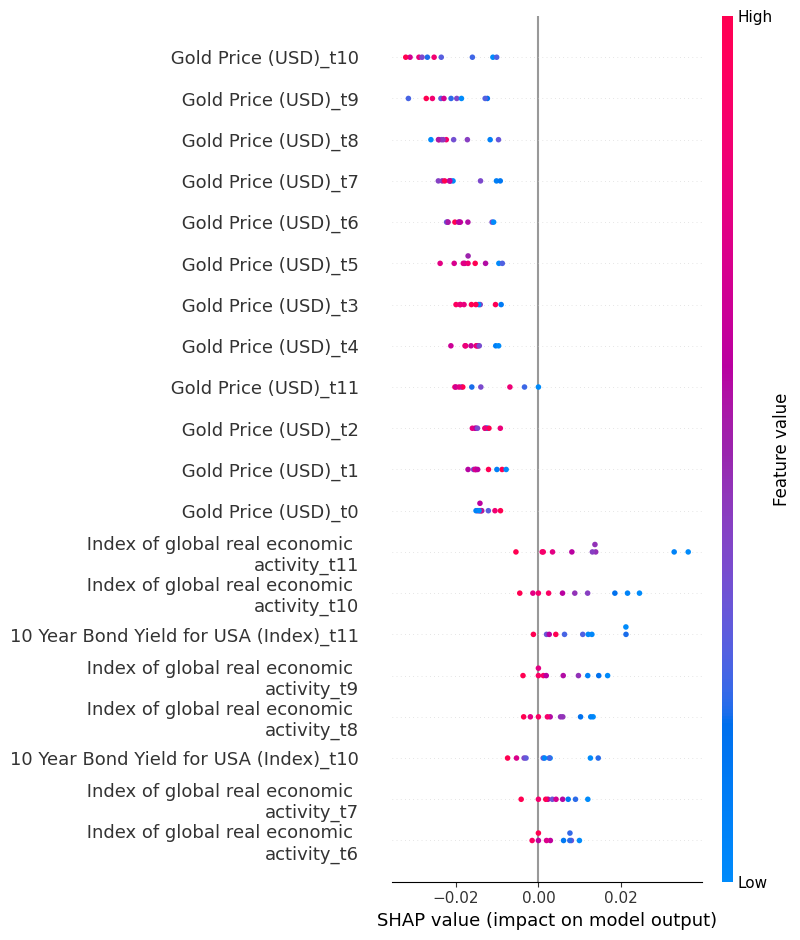

In [16]:
import shap

# Define a composite prediction function that accepts flattened input
def composite_predict(x_flat):
    # x_flat is of shape (n_samples, seq_length * n_features)
    n_samples = x_flat.shape[0]
    # Reshape it back to 3D: (n_samples, seq_length, n_features)
    reshaped = x_flat.reshape(n_samples, seq_length, len(feature_cols))
    # Extract LSTM features
    features = feature_extractor.predict(reshaped)
    # Get the final predictions from XGBoost
    return best_xgb.predict(features)

# Flatten a background dataset from the training set (KernelExplainer is computationally heavy)
background = X_train[:100].reshape(100, seq_length * len(feature_cols))

# Create the KernelExplainer using the flattened background
explainer = shap.KernelExplainer(composite_predict, background)

# Choose a small subset of test samples and flatten them
X_test_subset = X_test[:10].reshape(10, seq_length * len(feature_cols))

# Compute SHAP values on the flattened test subset
shap_values = explainer.shap_values(X_test_subset)

# Create feature names corresponding to each original column at each time step
feature_names = []
for t in range(seq_length):
    for col in feature_cols:  # feature_cols = ['USD_Index', 'Global_Economic_Activity', 'US_10Y_Bond_Yield', 'Gold_Price']
        feature_names.append(f"{col}_t{t}")

# Generate the SHAP summary plot using the flattened test subset
shap.summary_plot(shap_values, X_test_subset, feature_names=feature_names)

## Uncertainty Quantification Using Bootstrap Ensemble

In [17]:
# Import the resample utility for bootstrapping
from sklearn.utils import resample

# Define the number of ensemble models
n_models = 20
ensemble_predictions = []

# Retrieve best hyperparameters from the previous RandomizedSearchCV
params = rand_search.best_params_

# Train an ensemble of XGBoost models using bootstrapped samples of the training features
for i in range(n_models):
    # Create a bootstrapped training set
    X_train_boot, y_train_boot = resample(X_train_features, y_train, replace=True, random_state=42+i)

    # Initialize a new XGBoost regressor with the best hyperparameters
    model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42+i, **params)
    model.fit(X_train_boot, y_train_boot.ravel())

    # Predict on the test set using the current model
    preds = model.predict(X_test_features)
    ensemble_predictions.append(preds)

# Convert the list of predictions to a numpy array with shape (n_models, n_test_samples)
ensemble_predictions = np.array(ensemble_predictions)

# Compute the ensemble mean and standard deviation for each test sample
pred_mean = np.mean(ensemble_predictions, axis=0)
pred_std = np.std(ensemble_predictions, axis=0)

# Inverse-transform the mean predictions to the original scale
pred_mean_inv = scaler_y.inverse_transform(pred_mean.reshape(-1, 1))

# Compute the scaling factor from the MinMaxScaler to adjust the standard deviation
scaling_factor = scaler_y.data_max_ - scaler_y.data_min_
pred_std_inv = pred_std * scaling_factor

# Compute 95% confidence intervals assuming a normal distribution (mean ± 1.96*std)
upper_bound = pred_mean_inv + 1.96 * pred_std_inv.reshape(-1, 1)
lower_bound = pred_mean_inv - 1.96 * pred_std_inv.reshape(-1, 1)

# Inverse-transform the ground truth test set values
y_test_inv = scaler_y.inverse_transform(y_test)

# Display a few sample predictions with their uncertainty intervals
print("Sample predictions with uncertainty:")
for i in range(5):
    print(f"Prediction: {pred_mean_inv[i,0]:.2f}, 95% CI: [{lower_bound[i,0]:.2f}, {upper_bound[i,0]:.2f}], Actual: {y_test_inv[i,0]:.2f}")

Sample predictions with uncertainty:
Prediction: 94.71, 95% CI: [91.22, 98.20], Actual: 92.86
Prediction: 94.86, 95% CI: [91.65, 98.08], Actual: 92.67
Prediction: 86.01, 95% CI: [81.02, 90.99], Actual: 93.08
Prediction: 83.51, 95% CI: [80.38, 86.63], Actual: 94.55
Prediction: 82.69, 95% CI: [79.89, 85.49], Actual: 93.05


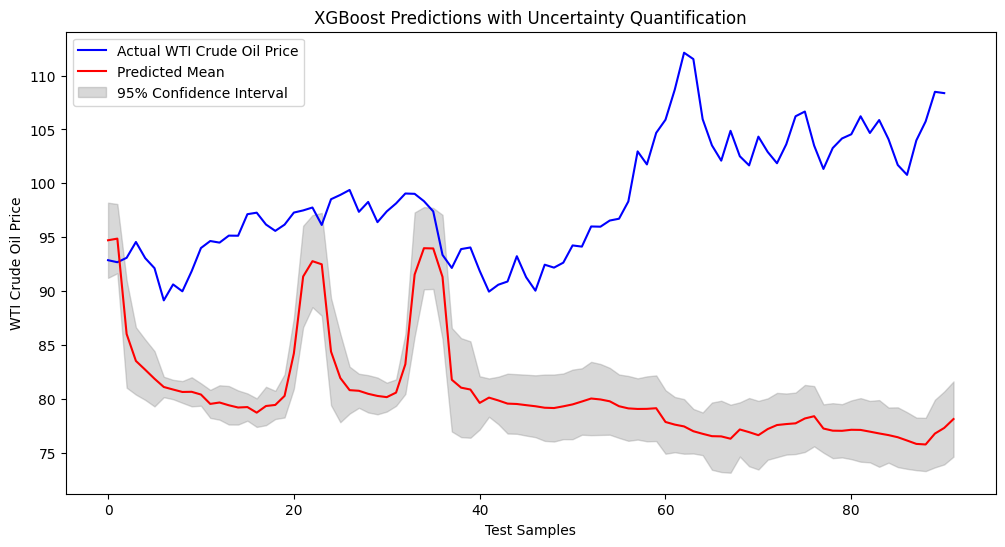

In [18]:
# Plot the ensemble mean predictions along with the 95% confidence intervals

plt.figure(figsize=(12,6))
plt.plot(y_test_inv, label='Actual WTI Crude Oil Price', color='blue')
plt.plot(pred_mean_inv, label='Predicted Mean', color='red')
plt.fill_between(range(len(pred_mean_inv)),
                 lower_bound.flatten(),
                 upper_bound.flatten(),
                 color='gray',
                 alpha=0.3,
                 label='95% Confidence Interval')
plt.xlabel("Test Samples")
plt.ylabel("WTI Crude Oil Price")
plt.title("XGBoost Predictions with Uncertainty Quantification")
plt.legend()
plt.show()